# Vitrine de popup

Popup = "population updater" est une micro-librairie d'optimisation par sélection génétique spécialement conçue pour les agents basés sur des réseaux neuronnaux. 

Cependant elle peut être utilisée pour tout problème d'optimisation, dès lors que l'on sépare l'ensemble des paramètres en 2 groupes: 
* Les poids (=`weights`)
* Les hyperparamètres (=`famparams`)

## Les imports

### Charger la lib popup

In [ ]:
#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    #!git pull https://github.com/vincentvigon/RECHERCHE3.git
    !git pull https://github.com/jaghili/popup.git
    %ls
else:
    print("on n'est pas sur colab")

import popup_lib.popup_cplx as pop
import random as rand

Reinitialized existing Git repository in /content/.git/
From https://github.com/jaghili/popup
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
ddqn_lib/  Hamilton/     model_vNet.h5  sample_data/
Euler/     Hamilton.zip  Pinns/         transformer/
GCN/       model_1.h5    popup_lib/     transformer_old/
GCN.zip    model_2.h5    poubel/        translations/


### Lib standarts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from typing import *
import tensorflow as tf
import scipy.optimize as sco
import scipy as sci
from scipy.interpolate import interp1d
import time
from matplotlib import cm

## Problème de Newton


In [ ]:
from sys import modules
class Agent_Newton(pop.Abstract_Agent):  # à modifier (Emmanuel) -> pour l'instant, ce n'est que de la classification

    def __init__(self, Newton, Newton_test,model, lr0, reg, decay, batch_size,n_lissage,omega=0.5,type_score=0,nb_opti=50):  # object newton
      # ajouter famparam de régularisation

        self.Newton_train = Newton
        self.Newton_test = Newton_test
        self.famparams = {"lr0": lr0, "reg": reg, "decay": decay, "batch_size":batch_size,"n_lissage":n_lissage,"omega":omega}
        self.type_score=type_score
        self._count = -1
        self.nb_optimization = nb_opti

        self.mse_losses = []
        self.val_mse_losses = []

        self.model = model
        if self.model.nn_name=='Unet':
          self.model = self.make_model_unet()
          self.nn_name='Unet'
        else:
          self.make_model_fno()
          self.nn_name='FNO'
        self.make_optimizer()

        n_loc= round(Newton_train.mesh.N/n_lissage)
        if n_loc%2 != 1: 
          n_loc=n_loc+1
        print("nb pixel lissage >>>",n_loc)
        print("omega>>",self.famparams["omega"])

    def get_famparams(self):
        return self.famparams

    def make_optimizer(self):
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            self.famparams["lr0"],
            decay_steps=100,
            decay_rate=self.famparams["decay"],
            staircase=True,
        )
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(lr_schedule),
            loss='mse',
            metrics=['mae', 'mse', 'mape']
        )

    # à modifier
    def set_and_perturb_famparams(self, famparams, period_count):
        self.famparams=famparams
        self.famparams["omega"] = max(1.0,min(0.0,self.famparams["omega"] * np.random.uniform(0.9, 1.1)))
        self.famparams["lr0"] = max(1e-5,min(1e-2,self.famparams["lr0"] * np.random.uniform(0.5, 2)))
        self.famparams["decay"] = max(0.9,min(1.0,self.famparams["decay"] * np.random.uniform(0.98, 1.02)))
        self.famparams["reg"] = 1.0#max(0.0,min(0.1,self.famparams["reg"] * np.random.uniform(0.5, 2.0)))
        self.famparams["batch_size"] = max(16,min(256,(self.famparams["batch_size"] * int(rand.choice([0.5,2.0]) ))))
        self.famparams["n_lissage"] = max(1,min(50,self.famparams["n_lissage"] + rand.choice([-2,2])))
        self.make_optimizer()

    def make_model_unet(self):
        reg = tf.keras.regularizers.l2(self.famparams["reg"])
        input_shape = self.Newton_train.X[0].shape
        inputs = tf.keras.Input(shape=input_shape, dtype=np.float32)

        Y = self.model.call(inputs)
        outputs = tf.keras.layers.Conv1D(1, 1)(Y) ###?????
        return tf.keras.Model(inputs=inputs, outputs=outputs)


    def make_model_fno(self):
      input_shape = self.Newton_train.X.shape
      inputs = tf.keras.Input(shape=input_shape, dtype=np.float32)
      Y = self.model.call(self.Newton_train.X)

    # dans Euler :
    def optimize_and_return_score(self) -> float:
        self.model.fit(self.Newton_train.X, self.Newton_train.Y, verbose=0, epochs=self.nb_optimization, batch_size=self.famparams["batch_size"],validation_split=0.0)
        res=self.agent_score()
        return res

    def optimize(self):
        omega = self.famparams["omega"]
        self._count += 1
        X, Y = self.Newton.get_batch(self.famparams["batch_size"])
        func_G= []
        for i in range(0,self.famparams["batch_size"]):
            self.Newton_train.f_loc = np.copy(X[i, :, 0])
            self.Newton_train.alpha_loc = np.copy(X[i, :, 1])
            func_G.append(self.Newton_train())

        with tf.GradientTape() as tape:
            Y_pred = self.model.call(X)
            # print(np.shape(Y), np.shape(Y_pred), np.shape(X))
            loss1 = tf.reduce_sum(tf.keras.losses.mse(Y, Y_pred))  
            loss2 = 0.0
            for i in range(0,self.famparams["batch_size"]):
              loss2 = loss2 + tf.reduce_sum(tf.keras.losses.mse(func_G[i](Y_pred),0.0*Y))
            loss = omega* loss1 + (1.0-omega ) *loss2

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    # def fit(self):
    #     print('**** Newton train X', self.Newton_train.X.shape)
    #     print('**** Newton train Y', self.Newton_train.Y.shape)
    #     print('**** batch size', self.famparams["batch_size"])
    #     history= self.model.fit(self.Newton_train.X, self.Newton_train.Y, verbose=0, epochs=80, batch_size=self.famparams["batch_size"],validation_split=0.1)
    #     plt.plot(history.history['mse'])
    #     plt.plot(history.history['val_mse'])
    #     plt.title('model mse')
    #     plt.ylabel('loss')
    #     plt.xlabel('epoch')
    #     plt.legend(['train', 'test'], loc='upper left')
    #     plt.show()   

    def fit(self, epochs=80):
        print('**** Newton train X', self.Newton_train.X.shape)
        print('**** Newton train Y', self.Newton_train.Y.shape)
        print('**** batch size', self.famparams["batch_size"])
        history= self.model.fit(
          self.Newton_train.X, self.Newton_train.Y, verbose=0,
          epochs=epochs, batch_size=self.famparams["batch_size"],validation_split=0.1
        )
        for loss in history.history['mse']:
          self.mse_losses.append(loss)
        for loss in history.history['val_mse']:
          self.val_mse_losses.append(loss)
        n = len(self.mse_losses)
        print("total number of epochs = ", n)
        plt.semilogy(np.arange(n//4, n), self.mse_losses[n//4:])
        plt.semilogy(np.arange(n//4, n), self.val_mse_losses[n//4:])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()  

    def test_inverse_train(self,i,agent=True):
        U_ref= self.Newton_train.Y[i, :, 0]
        self.Newton_train.f_loc = np.copy(self.Newton_train.X[i, :, 0])
        self.Newton_train.alpha_loc = np.copy(self.Newton_train.X[i, :, 1])
        U0= self.predict_lisser(False)

        print(" init residu:")
        print("Erreur G(u0): ",np.sqrt(np.sum((self.Newton_train(U0[0,:,0]))**2.0)))
        print("Erreur G(0): ",np.sqrt(np.sum((self.Newton_train(np.zeros_like(U0[0,:,0])))**2.0)))

        def l2norm(x):
          return np.linalg.norm(x);
        
        options={'maxiter':2000,'disp':False,'tol_norm':l2norm, 'ftol':1e-6, 'fatol':1e-6,'jac_options':{'inner_maxiter':1000}}
        if agent==False:
          print(" last test : basic solution")
          sol_ref = sco.root(self.Newton_train, np.ones_like(U0[0,:,0]),method='krylov',options=options)
        else:
          print(" last test : agent solution")
          sol_ref = sco.root(self.Newton_train,U0[0,:,0],method='krylov',options=options)

        if sol_ref.success:
          U_final=sol_ref.x
          niter= sol_ref.nit
        else:
          U_final=sol_ref.x
          niter= 2000 
        print(">>>> nb iter to converge >>",niter," final error >>",l2norm(sol_ref.fun)," message >>",sol_ref.message)
        print(">>>> Test final")
        if agent==True:
          print("Erreur F_theta(0)-U_ref: ",np.sqrt(np.sum(self.Newton_train.mesh.h*np.abs(self.Newton_train.Y[i, :, 0] - U0[0,:,0])**2.0)))
          fig, ax = plt.subplots(2, 2, figsize=(16, 6))
          ax[0,0].plot(self.Newton_train.mesh(),U0[0,:,0],label="U")
          ax[0,0].plot(self.Newton_train.mesh(),U_ref,label='U ref')
          ax[0,1].plot(self.Newton_train.mesh(),U0[0,:,0]-U_ref,label="error init")
          ax[0,1].plot(self.Newton_train.mesh(),U_final[:]-U_ref,label="error final")
          ax[1,0].plot(self.Newton_train.mesh(),self.Newton_train.elliptic(U0[0,:,0]),label="Ope(U)")
          ax[1,0].plot(self.Newton_train.mesh(),self.Newton_train.elliptic(U_ref),label='Ope(U ref)')
          ax[1,1].plot(self.Newton_train.mesh(),self.Newton_train(U0[0,:,0]),label="G(U) on résout G(U)=0")
          ax[1,1].plot(self.Newton_train.mesh(),self.Newton_train(np.zeros_like(U0[0,:,0])),label='G(0)')
          plt.legend()
        return niter

    def test_inverse_test(self,basic=False,plot=False):
        X_test, Y_test= self.Newton_test.generate_data_test()
        self.Newton_test.f_loc = np.copy(X_test[:, 0])
        self.Newton_test.alpha_loc = np.copy(X_test[ :, 1])
        U_ref= Y_test[:, 0]
        U0=self.predict_lisser(True)

        print("Size of problem:",Y_test.shape," init residu:")
        print("Erreur G(u0): ",np.sqrt(np.sum((self.Newton_test(U0[0,:,0]))**2.0)))
        print("Erreur G(0): ",np.sqrt(np.sum((self.Newton_test(np.zeros_like(U0[0,:,0])))**2.0)))

        def l2norm(x):
          return np.linalg.norm(x);

        options={'maxiter':2000,'disp':False,'tol_norm':l2norm, 'ftol':1e-6, 'fatol':1e-6,'jac_options':{'inner_maxiter':1000}}
        if basic==True:
          print(" last test : basic solution")
          sol_ref_basic = sco.root(self.Newton_test, np.ones_like(U0[0,:,0]),method='krylov',options=options)

          if sol_ref_basic.success:
            U_final=sol_ref_basic.x
            niter_basic= sol_ref_basic.nit
          else:
            U_final=sol_ref_basic.x
            niter_basic= 2000 

        print(" last test : agent solution")
        sol_ref_agent = sco.root(self.Newton_test,U0[0,:,0],method='krylov',options=options)
        if sol_ref_agent.success:
          U_final=sol_ref_agent.x
          niter_agent= sol_ref_agent.nit
        else:
          U_final=sol_ref_agent.x
          niter_agent= 2000 

        if basic==True:
          print(">>>> Basic: nb iter to converge >>",niter_basic," final error >>",l2norm(sol_ref_basic.fun)," message >>",sol_ref_basic.message)
        print(">>>> Agent: nb iter to converge >>",niter_agent," final error >>",l2norm(sol_ref_agent.fun)," message >>",sol_ref_agent.message)
        print(">>>> Test final")
        if plot==True:
          print("Erreur F_theta(0)-U_ref: ",np.sqrt(np.sum(self.Newton_test.mesh.h*np.abs(Y_test[:, 0] - U0[0,:,0])**2.0)))
          fig, ax = plt.subplots(2, 2, figsize=(16, 6))
          ax[0,0].plot(self.Newton_test.mesh(),U0[0,:,0],label="U")
          ax[0,0].plot(self.Newton_test.mesh(),U_ref,label='U ref')
          ax[0,1].plot(self.Newton_test.mesh(),U0[0,:,0]-U_ref,label="error init")
          ax[0,1].plot(self.Newton_test.mesh(),U_final[:]-U_ref,label="error final")
          ax[1,0].plot(self.Newton_test.mesh(),self.Newton_test.elliptic(U0[0,:,0]),label="Ope(U)")
          ax[1,0].plot(self.Newton_test.mesh(),self.Newton_test.elliptic(U_ref),label='Ope(U ref)')
          ax[1,1].plot(self.Newton_test.mesh(),self.Newton_test(U0[0,:,0]),label="G(U) on résout G(U)=0")
          ax[1,1].plot(self.Newton_test.mesh(),self.Newton_test(np.zeros_like(U0[0,:,0])),label='G(0)')
          plt.legend()
        return niter_agent

    def test_stats_loc(self,i,plot=False,val=True):
        if val==True:
            X_test = self.Newton_test.data_val[i][0]
            Y_test = self.Newton_test.data_val[i][1]
        else:
            X_test, Y_test= self.Newton_test.generate_data_test()
        self.Newton_test.f_loc = np.copy(X_test[:, 0])
        self.Newton_test.alpha_loc = np.copy(X_test[ :, 1])
        U_ref= Y_test[:, 0]
        basic_time=0.0
        agent_time=0.0

        def l2norm(x):
          return np.linalg.norm(x);

        options={'maxiter':2000,'tol_norm':l2norm, 'ftol':1e-6, 'fatol':1e-6,'jac_options':{'inner_maxiter':1000}}

        try:
          start_time = time.time()
          sol_ref_basic = sco.root(self.Newton_test, np.ones_like(U_ref),method='krylov',options=options)
          basic_time = time.time()-start_time
          if sol_ref_basic.success:
            U_final=sol_ref_basic.x
            niter_basic= sol_ref_basic.nit
          else:
            U_final=sol_ref_basic.x
            niter_basic= 2000
        except ValueError: 
          U_final=np.ones_like(U_ref)
          niter_basic= 2000

        try:
          start_time2 = time.time()
          U0=self.predict_lisser(True)
          sol_ref_agent = sco.root(self.Newton_test,U0[0,:,0],method='krylov',options=options)
          agent_time = time.time()-start_time2
          if sol_ref_agent.success:
            U_final=sol_ref_agent.x
            niter_agent= sol_ref_agent.nit
          else:
            U_final=sol_ref_agent.x
            niter_agent= 2000 
        except ValueError: 
          U_final=U0[0,:,0]
          niter_agent= 2000

        if plot==True:
          print(">>>> Basic: nb iter to converge >>",niter_basic," final error >>",l2norm(sol_ref_basic.fun)," message >>",sol_ref_basic.message)
          print(">>>> Agent: nb iter to converge >>",niter_agent," final error >>",l2norm(sol_ref_agent.fun)," message >>",sol_ref_agent.message)
          print(">>>> ratio >>>>",niter_basic/niter_agent,">>>> tratio >>>>",basic_time/agent_time," >>> ratio mesh >>> ",len(X_test[:, 0])/self.Newton_train.N)
        return [niter_basic,niter_agent,basic_time,agent_time,len(X_test[:, 0]),len(X_test[:, 0])/self.Newton_train.N]



    def output_stats(self,n_test=1,vali=True):
      niter_a=0.0
      niter_b=0.0
      time_b=0.0
      time_a=0.0
      ratio_i = np.zeros(n_test)
      ratio_t = np.zeros(n_test)
      tmesh = np.zeros(n_test)
      r_mesh = np.zeros(n_test)
      nb_ratio_larger_un=np.zeros(n_test,dtype=int)

      mean_i =0.0
      mean_t =0.0
      mean_mesh_i=np.zeros(len(self.Newton_test.meshes),dtype=float)
      mean_mesh_t=np.zeros(len(self.Newton_test.meshes),dtype=float)
      nb_mesh=np.zeros(len(self.Newton_test.meshes),dtype=int)
      for i in range(0,n_test):
        if i%10==0:
          print(">>> iter >>>",i)
        niter_b,niter_a,time_b,time_a,loc_mesh,ra_mesh= self.test_stats_loc(i,plot=False,val=vali)
        ratio_i[i]= niter_b/niter_a
        ratio_t[i]= time_b/time_a
        tmesh[i] = loc_mesh
        r_mesh[i] = ra_mesh
        if niter_a > niter_b:
          nb_ratio_larger_un[i]=1

        mean_t= mean_t + ratio_t[i]
        mean_i= mean_i + ratio_i[i]
        index_mesh=self.Newton_test.meshes.index(loc_mesh)
        mean_mesh_i[index_mesh]= mean_mesh_i[index_mesh]+ ratio_i[i]
        mean_mesh_t[index_mesh]= mean_mesh_t[index_mesh]+ ratio_t[i]
        nb_mesh[index_mesh]+=1
        

      mean_t/=n_test
      mean_i/=n_test
      for i in range(0,len(self.Newton_test.meshes)):
        mean_mesh_i[i]/=nb_mesh[i]
        mean_mesh_t[i]/=nb_mesh[i]

      return [ratio_i,ratio_t,tmesh,r_mesh,nb_ratio_larger_un,mean_i,mean_t,mean_mesh_i,mean_mesh_t,nb_mesh ]

    def predict_lisser(self,val=False):
        if val==False :
          input = (np.vstack((self.Newton_train.f_loc,self.Newton_train.alpha_loc)).T)[np.newaxis,:,:]
          U = self.model.predict(input) 
          for i in range(np.shape(U)[0]):
            U[i,:,0]=self.lisser(U[i,:,0],self.famparams["n_lissage"],self.Newton_train.N)
        else:
          if self.nn_name=='Unet' and (self.Newton_train.mesh.N != self.Newton_test.mesh.N):
          ## interpolate
            mesh_train=self.Newton_train.mesh()
            mesh_test=self.Newton_test.mesh()

            f_loc = interp1d(mesh_test, self.Newton_test.f_loc,kind='cubic',bounds_error=False) 
            f_loc_train = f_loc(mesh_train)
            alpha_loc = interp1d(mesh_test,self.Newton_test.alpha_loc,kind='cubic',bounds_error=False) 
            alpha_loc_train = alpha_loc(mesh_train)

            input = (np.vstack((f_loc_train,alpha_loc_train)).T)[np.newaxis,:,:]
            Utrain = self.model.predict(input) 

            U = np.zeros((np.shape(Utrain)[0], self.Newton_test.mesh.N, 1))
            for i in range(np.shape(Utrain)[0]):
              Utrain[i,:,0]=self.lisser(Utrain[i,:,0],self.famparams["n_lissage"],self.Newton_train.mesh.N) 
              sol = interp1d(mesh_train,Utrain[i,:,0],kind='cubic',bounds_error=False)
              U[i,:,0]= sol(mesh_test)
            if self.Newton_test.N> self.Newton_train.N:
              U[i,:,0]=self.lisser(U[i,:,0],12,self.Newton_test.mesh.N)
          else:
            input = (np.vstack((self.Newton_test.f_loc,self.Newton_test.alpha_loc)).T)[np.newaxis,:,:]
            if self.nn_name=='Unet':
              U = self.model.predict(input)
            else:
              U = self.model.call(input)
              U = U.numpy()
            for i in range(np.shape(U)[0]):
              U[i,:,0]=self.lisser(U[i,:,0],self.famparams["n_lissage"],self.Newton_test.mesh.N)

        return U

    def lisser(self,q, n=11,size=256): 
      if n==0 or n==1: return q
      n_loc= round(size/n)
      if n_loc%2 != 1: 
        n_loc=n_loc+1
      x = np.linspace(-3,3,n_loc)
      kernel = np.exp(-0.5*x**2)
      kernel /= np.sum(kernel)
      if len(q.shape) == 1:
        qa = np.concatenate([q[-(n_loc//2):], q, q[:n_loc//2]])
        return np.convolve(qa, kernel, 'valid')
      else:
        qa = np.concatenate([q[:,-(n_loc//2):], q, q[:,:n_loc//2]], axis=1)
        return np.apply_along_axis(np.convolve, 1, qa, kernel, 'valid')

    def agent_score(self) -> float:  # c'est le score de l'agent
        res=0.0
        N_v= 40
        if self.type_score==0: 
          m_loss=0.0
          for i in range(0, N_v): 
            X_test = self.Newton_test.data_val[i][0]
            Y_test = self.newton_test.data_val[i][1]
            self.Newton_test.f_loc = np.copy(X_test[:, 0])
            self.Newton_test.alpha_loc = np.copy(X_test[:, 1])
            Y_pred=self.predict_lisser(True) 
            loss = np.linalg.norm(Y_test[:, 0]- Y_pred[0,:,0])*np.sqrt(self.Newton_test.mesh.h)
            m_loss = m_loss+loss
          res= m_loss / N_v
          res=1.0/res  
          
        else:
          ratio_i,ratio_t,tmesh,r_mesh,nb_ratio_larger_un,mean_i,mean_t,mean_mesh_i,mean_mesh_t,nb_mesh = self.output_stats(N_v,vali=True)
          res = mean_i
        return res

    def set_weights(self, weights: List):
        self.model.set_weights(weights)

    def get_copy_of_weights(self) -> List:
        # la méthode .get_weights() des tf.keras.Model renvoie une liste contenant la copie de tous les poids
        # ne pas confondre avec l'attribut .trainable_variables qui n'est pas une copie
        return self.model.get_weights()

In [ ]:
class mesh:
  def __init__(self, N, a, b):
    self.N = N
    self.a = a
    self.b = b
    self.m = np.linspace(a,b,N)
    self.h= abs(self.m[1]-self.m[0])

  def remesh(self,N):
    self.N=N
    self.m = np.linspace(self.a,self.b,N)
    self.h= abs(self.m[1]-self.m[0])

  def __call__(self):
    return self.m

In [ ]:
class Newton:  # à modifier /creation des jeux de données

    def __init__(self, N, a, b,
               k=lambda u: np.ones_like(u),
               kp=lambda u: np.zeros_like(u),
               nb_eq=1, nb_sol_by_eq=1,
               ubc=0.0,
               bc='Neumann'):
        self.nb_data = nb_eq* nb_sol_by_eq
        self.nb_eq =nb_eq
        self.nb_sol_by_eq = nb_sol_by_eq
        self.k = k
        self.kp = kp
        self.bc = bc
        self.ubc = ubc
        self.N = N
        if self.bc=='Neumann':
          self.f_type=1
        else:
          self.f_type=0
        self.mesh=mesh(N,a,b)
        self.meshes= [80,100,128,200,256,400,512,700]


        print('====== Init ======')
        print('mesh size: ', np.size(self.mesh))
        print('mesh step: ', self.mesh.h)
        print('bc type  : ', self.bc)

        self.X = np.zeros((self.nb_data, N, 2))  #  f , alpha
        self.Y = np.zeros((self.nb_data, N, 1))  # u
        self.X_shuffle = np.zeros((self.nb_data, N, 2))  #  f , alpha
        self.Y_shuffle = np.zeros((self.nb_data, N, 1))  # u
        self.data_val = []

    def elliptic(self, U):
      h = self.mesh.h
      Up = np.roll(U, -1) # Up = U_i+1
      Um = np.roll(U,  1) # Um = U_i-1
      # reaction term
      reac = self.alpha_loc*U
      # BC
      if self.bc == 'Dirichlet':
        Um[0]  = self.ubc
        Up[-1] = self.ubc

        # diffusion terms
        Kp = 0.5 * (self.k(U) + self.k(Up))
        Km = 0.5 * (self.k(Um) + self.k(U))
        diff = - (Kp * (Up - U) - Km * ( U - Um)) / h**2

      elif self.bc == 'Neumann':
        # diffusion terms
        Kp = 0.5 * (self.k(U) + self.k(Up))
        Km = 0.5 * (self.k(Um) + self.k(U))

        diff     = - (Kp * (Up - U) - Km * ( U - Um)) / h**2
        diff[0]  =  - (Kp[0]*(Up[0] - U[0]) + self.ubc) / h**2          # - Km * (U - Um) = uL neumann on left boundary
        diff[-1] =  - ( -self.ubc - Km[-1] * (U[-1] - Um[-1])) / h**2   # - Kp * (Up - U) = uR neumann on right boundary
      else:
        print('Not yet implemented.')
        exit(1)

      return reac + diff

    def __call__(self, U):
        ellip = self.elliptic(U)
        res = ellip - self.f_loc
        return res

    def generate_fourier(self, a0=0.0,f_type=0):
        if f_type==0:
          nbFourierCoef = np.random.randint(1, 7)
          n = np.arange(1, nbFourierCoef + 1)
          an = np.random.uniform(-1, 1, nbFourierCoef) / n

          nu = 2 * np.pi / (self.mesh.b - self.mesh.a)
          res = a0 + np.sum(an * np.sin(np.outer(self.mesh(), n) * nu), axis=1)
          self.ubc=a0
        else:
          res=0.0
          nb_g= rand.randint(0,6)
          x_0=(self.mesh.a+self.mesh.b)/2
          L=self.mesh.b-self.mesh.a
          std=np.random.uniform(0.025,0.08)
          res=sci.stats.norm.pdf(self.mesh(),np.random.uniform(x_0-0.25*L,x_0+0.25*L),std)
          for i in range(1,nb_g):
            std=np.random.uniform(0.025,0.07)
            res=res+sci.stats.norm.pdf(self.mesh(),np.random.uniform(x_0-0.25*L,x_0+0.25*L),std)
          res=res/np.max(res)+0.5
        return res

    def generate_data_train(self):
        # construct random f,u,alpha and compute g(u)
        for i in range(0,self.nb_eq):
          self.X[i, :, 1] = self.generate_fourier(a0=1.5,f_type=self.f_type)
          self.alpha_loc = np.copy(self.X[i, :, 1])
          for k in range(0,self.nb_sol_by_eq):
            U=self.generate_fourier(a0=1.2,f_type=self.f_type)
            self.Y[i, :, 0] = U  # generate u
            EllipticU= self.elliptic(U)
            self.X[i, :, 0] = EllipticU  # generate f

        print(">>> end generate >>>")

    def generate_data_val(self):

        for i in range(0,self.nb_eq):
          N= np.random.choice(self.meshes)
          self.mesh.remesh(N)
          X_test = np.zeros((N, 2))  #  f , alpha
          Y_test = np.zeros((N, 1))  # u

          X_test[:, 1] = self.generate_fourier(a0=1.5,f_type=self.f_type)
          self.alpha_loc = np.copy(X_test[:, 1])
          U=self.generate_fourier(a0=1.2,f_type=self.f_type)
          Y_test[:, 0] = U  # generate u
          EllipticU= self.elliptic(U)
          X_test[:, 0] = EllipticU  # generate f
          self.data_val.append((X_test,Y_test,N))

    def generate_data_test(self):
        Nn=self.N
        N= np.random.choice(self.meshes)
        self.mesh.remesh(N)
        X_test = np.zeros((N, 2))  #  f , alpha
        Y_test = np.zeros((N, 1))  # u

        X_test[:, 1] = self.generate_fourier(a0=1.5,f_type=self.f_type)
        self.alpha_loc = np.copy(X_test[:, 1])
        U=self.generate_fourier(a0=1.2,f_type=self.f_type)
        Y_test[:, 0] = U  # generate u
        EllipticU= self.elliptic(U)
        X_test[:, 0] = EllipticU  # generate f
        return X_test,Y_test

    def shuffle(self):
        perm = np.random.permutation(len(self.X))
        self.X_shuffle = self.X[perm]
        self.Y_shuffle = self.Y[perm]
        self.batch_count = 0

    def get_batch(self, batch_size):
        i = self.batch_count
        self.batch_count += 1

        if (i + 1) * batch_size >= len(self.X):
            self.shuffle()

        X_batch = self.X_shuffle[i * batch_size:(i + 1) * batch_size]
        Y_batch = self.Y_shuffle[i * batch_size:(i + 1) * batch_size]
        return X_batch, Y_batch

    def plot_data(self, i):
        fig, ax = plt.subplots(2, 2, figsize=(16, 6))
        ax[0, 0].plot(self.mesh(), self.X_train[i, :, 0], label="f(x)")
        ax[0, 1].plot(self.mesh(), self.X_train[i, :, 1], label="alpha(x)")
        ax[1, 0].plot(self.mesh(), self.Y_train[i, :, 0], label="u(x)")
        ax[1, 1].plot(self.mesh(), self(self.Y_train[i, :, 0]), label="G(u(x))")

## Agent et réseaux

In [ ]:
class ContinuousPadding1D(tf.keras.layers.Layer):

    def __init__(self, padding, **kwargs):
        super(ContinuousPadding1D, self).__init__(**kwargs)
        self.padding = padding

    def call(self, inputs):
        return tf.concat([inputs[:,:1,:]*tf.ones((1, self.padding, 1)),
                          inputs,
                          inputs[:,-1:,:]*tf.ones((1, self.padding, 1))], axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+2*self.padding, input_shape[2])

    def get_config(self):
        config = {'padding': self.padding}
        base_config = super(ContinuousPadding1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def reflexive_padding( W: tf.Tensor, pad: int):
  return tf.pad(W,[[0,0],[pad,pad],[0,0]])

class SpectralConv1d_plus(tf.keras.layers.Layer):

    def __init__(self, in_channels:int, out_channels:int, modes:int,first_channel_unchanged:bool,N_out_imposed=None,freq_mix_size=0):
        super().__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes  #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.N_out_imposed=N_out_imposed
        self.first_channel_unchanged=first_channel_unchanged
        self.freq_mix_size=freq_mix_size

        self.multiplicative_weights =tf.Variable(self.get_complex_weights(),name="mutliplicative")

        self.kerner_for_freq_conv_real=None
        self.kerner_for_freq_conv_imag=None
        if self.freq_mix_size>1:
            self.kerner_for_freq_conv_real=tf.Variable(self.get_kernel_for_freq_conv())
            self.kerner_for_freq_conv_imag=tf.Variable(self.get_kernel_for_freq_conv())


    def get_complex_weights(self):
        if self.first_channel_unchanged:
            return self.get_complex_weights_for_first_channel_unchanged()
        else:
            return self.get_complex_weights_classic()

    def inspect_weiths(self):


        def plot_conv_kernels(kernel1,kernel2,title):
            _, in_ch, out_ch = kernel1.shape
            fig, axs = plt.subplots(in_ch,out_ch,figsize=(20,20),sharey="all",sharex="all")
            fig.suptitle(title)

            for i in range(in_ch):
                for j in range(in_ch):
                    axs[i,j].plot(kernel1[:,i,j])
                    axs[i,j].plot(kernel2[:,i,j])
            plt.show()

        def plot_mult_kernels(kernel1,kernel2,title):
            in_ch, out_ch,_ = kernel1.shape
            fig, axs = plt.subplots(in_ch,out_ch,figsize=(20,20),sharey="all",sharex="all")
            fig.suptitle(title)

            for i in range(in_ch):
                for j in range(in_ch):
                    axs[i,j].plot(kernel1[i,j,:])
                    axs[i,j].plot(kernel2[i,j,:])
            plt.show()


        if self.kerner_for_freq_conv_real is not None:
            plot_conv_kernels(self.kerner_for_freq_conv_real,self.kerner_for_freq_conv_imag,"kerner_for_freq_conv real/imag")

        plot_mult_kernels(tf.math.real(self.multiplicative_weights),tf.math.imag(self.multiplicative_weights),"multiplicative filter real/imag")


    def get_complex_weights_classic(self):
        scale = (1 / (self.in_channels*self.out_channels))
        real = tf.random.uniform([self.in_channels, self.out_channels, self.modes])
        img =  tf.random.uniform([self.in_channels, self.out_channels, self.modes])
        return tf.complex(real,img)*scale

    def get_complex_weights_for_first_channel_unchanged(self):
        scale = (1 / (self.in_channels*self.out_channels))
        real = np.random.uniform(0.,1,size=[self.in_channels, self.out_channels, self.modes]).astype(np.float32)
        img =  np.random.uniform(0.,1,size=[self.in_channels, self.out_channels, self.modes]).astype(np.float32)
        real[:,0,:]=1
        img[:,0,:]=0.
        return tf.complex(real,img)*scale


    def channel_mix(self, inputs, weights):
        # (batch, in_channel, mode ), (in_channel, out_channel, mode) -> (batch, out_channel, mode)
        """ sum_i inputs[b,i,A] weights[i,o,A]  """
        return tf.einsum("bix,iox->box", inputs, weights)

    def freq_conv(self,B,kernel):
        list_GPU=tf.config.list_physical_devices('GPU')
        if len(list_GPU)==0:
            #print("pas de GPU")
            B=tf.transpose(B,[0,2,1])
            B=tf.nn.conv1d(B, kernel, stride=1, padding="VALID", data_format="NWC")
            return tf.transpose(B,[0,2,1])
        else:
            #print("GPU")
            return tf.nn.conv1d(B,kernel,stride=1,padding="VALID",data_format="NCW")


    def get_kernel_for_freq_conv(self):
        kernel=np.zeros([self.freq_mix_size*self.out_channels**2]).astype(np.float32)
        kernel=np.reshape(kernel,[self.freq_mix_size,self.out_channels,self.out_channels])
        kernel[0,:,:]=1.

        # Todo: autre choix
        # kernel = np.ones([self.freq_mix_size * self.out_channels ** 2]).astype(np.float32)/(self.freq_mix_size * self.out_channels ** 2)
        # kernel = np.reshape(kernel, [self.freq_mix_size, self.out_channels, self.out_channels])
        # Todo: autre choix
        #kernel = tf.random.uniform([self.freq_mix_size, self.out_channels, self.out_channels])/(self.freq_mix_size * self.out_channels ** 2)
        return kernel

    def freq_mix(self,A):
        A_real=tf.math.real(A)
        A_imag=tf.math.imag(A)

        A_real=self.freq_conv(A_real,self.kerner_for_freq_conv_real)
        A_imag=self.freq_conv(A_imag,self.kerner_for_freq_conv_imag)

        return tf.complex(A_real,A_imag)


    # @tf.function
    def call(self, x):

        batch_size,N,c=x.shape
        if self.N_out_imposed is None:
            N_out=N
        else:
            N_out=self.N_out_imposed

        #on passe en format channel-first, à cause de la fft qui est implémentée ainsi
        x=tf.transpose(x,[0,2,1])
        x_ft = tf.signal.rfft(x)/N

        # Multiply relevant Fourier modes
        tf.assert_greater(N,2*self.modes,f"la taille du signal en entrée est trop petite pour le nombre de mode demandé")

        out_ft = self.channel_mix(x_ft[:, :, :self.modes], self.multiplicative_weights)

        if self.freq_mix_size>1:
            out_ft=self.freq_mix(out_ft) #diminue un peu la taille
        """
        Attention au rfft
        le nombre d'élément de rfft(x) c'est N//2+1
        [...,10]=> [...,6]
        [...,9]=>  [...,5]
        """
        to_add=N_out//2+1 - out_ft.shape[2]
        tf.assert_greater(to_add,0,f"la taille du signal en sortie est trop petite pour le nombre de mode demandé")
        out_ft_pad=tf.pad(out_ft, [[0, 0], [0, 0], [0, to_add]])

        #Return to physical space
        x = tf.signal.irfft(out_ft_pad,fft_length=[N_out])*N_out
        x=tf.transpose(x,[0,2,1])

        return x

In [ ]:
class Unet(tf.keras.Model):  # à modifier (Emmanuel) -> pour l'instant, ce n'est que de la classification

    def __init__(self,Unet_struc=None):  # object newton
      # ajouter famparam de régularisation
        super().__init__()
        self.nn_name='Unet'
        self.kernel_size = Unet_struc[2]
        self.levels = Unet_struc[0]
        self.depth = Unet_struc[1]
        self.up_kernel_size = Unet_struc[3]

        self.activation = 'relu' ## gelu pas mal, softplus non sur les plateaux
        self.batch_norm = True
        self.up_constant_init = True
        self.reg =0.0000

    def doubleConv(self, Y, depth):
        reg = tf.keras.regularizers.l2(self.reg)
        Y = tf.keras.layers.ZeroPadding1D(self.kernel_size // 2)(Y)# ContinuousPadding1D(self.kernel_size // 2)(Y)
        Y = tf.keras.layers.Conv1D(depth, self.kernel_size,
                                   activation=self.activation,
                                   padding='valid',
                                   kernel_regularizer=reg)(Y)
        Y = tf.keras.layers.ZeroPadding1D(self.kernel_size // 2)(Y)#Y = ContinuousPadding1D(self.kernel_size // 2)(Y)
        Y = tf.keras.layers.Conv1D(depth, self.kernel_size,
                                   activation=self.activation,
                                   padding='valid', use_bias=False,
                                   kernel_regularizer=reg)(Y)
        if self.batch_norm:
            Y = tf.keras.layers.BatchNormalization()(Y)
        # self.dropout_rate = 0
        # Y = tf.keras.layers.SpatialDropout1D(self.dropout_rate)(Y)
        return Y

    def makeDown(self, Y, depth):
        reg = tf.keras.regularizers.l2(self.reg)
        down = tf.keras.layers.Conv1D(depth, 2, strides=2,
                                      padding="same", activation=self.activation,
                                      kernel_regularizer=reg)(Y)
        return down

    def makeUp(self, Y, depth):
        reg = tf.keras.regularizers.l2(self.reg)
        Y = tf.keras.layers.UpSampling1D()(Y)
        if self.up_constant_init:
            up = tf.keras.layers.Conv1D(depth, self.up_kernel_size,
                                    activation=self.activation, padding="same",
                                  kernel_initializer=tf.keras.initializers.Constant(value=1 / self.up_kernel_size / depth),
                                  kernel_regularizer=reg)(Y)
        else:
            up = tf.keras.layers.Conv1D(depth, self.up_kernel_size,
                                    activation=self.activation, padding="same",
                                    kernel_regularizer=reg)(Y)
        return up

    def call(self, inputs):
        print('APPEL CALL()')
        left = {}
        left[0] = self.doubleConv(inputs, self.depth)
        for i in range(1, self.levels):
            print('i=',i)
            down = self.makeDown(left[i - 1], self.depth * 2**i)
            conv = self.doubleConv(down, self.depth * 2**i)
            left[i] = tf.keras.layers.Add()([down, conv])
        right = left[self.levels - 1]
        for i in range(self.levels - 2, -1, -1):
            print('i=',i)
            up = self.makeUp(right, self.depth * 2**i)
            add = tf.keras.layers.Add()([left[i], up])
            conv = self.doubleConv(add, self.depth * 2**i)
            right = tf.keras.layers.Add()([up, conv])
        print('shape call',right.shape)
        return right

In [ ]:
class FNO1d_plus(tf.keras.Model):
    def __init__(self, modes:int, width:int,out_channels,first_channel_unchanged,pad_prop,freq_mix_size):
        super().__init__()

        self.modes = modes
        self.width = width
        self.out_channels=out_channels
        self.first_channel_unchanged=first_channel_unchanged
        self.pad_prop=pad_prop
        self.freq_mix_size=freq_mix_size
        level=4

        print(f"modèle FNO1d crée avec comme hyperparamètre: modes:{modes}, width:{width},level:{level}, pad_prop:{pad_prop} ")

        self.fc0 = tf.keras.layers.Dense(self.width)

        self.convs=[SpectralConv1d_plus(
            in_channels=self.width,
            out_channels=self.width,
            modes=self.modes,
            first_channel_unchanged=self.first_channel_unchanged,
            N_out_imposed=None ,
            freq_mix_size=self.freq_mix_size) for _ in range(level)]
        self.ws=[tf.keras.layers.Conv1D(self.width,1) for _ in range(level)]

        self.fc1 = tf.keras.layers.Dense(128)
        self.fc2 = tf.keras.layers.Dense(self.out_channels)

        self.nn_name = "FNO1D_plus"


    @tf.function
    def call(self, A):
      #  print("traçage de la fonction call_acc")

        pad=int(A.shape[1]*self.pad_prop)
        A=reflexive_padding(A,pad)

        A = self.fc0(A)

        for i,(layer,w) in enumerate(zip(self.convs,self.ws)):
            x1=layer.call(A)
            x2=w(A)
            A= x1 + x2
            if i!=len(self.convs)-1:
                A=tf.nn.gelu(A)

        A=A[:,pad:-pad,:]

        A = self.fc1(A)
        A = tf.nn.gelu(A)
        A = self.fc2(A)

        return A

### L'agent


## Test Neuman sans algo genetique


In [ ]:
ku2     = lambda u : u**4 +1.0   
kpu2    = lambda u : 4.0*u*u*u 
#ku2     = lambda u : np.ones_like(u)
#kpu2    = lambda u : np.zeros_like(u)
Newton_train=Newton(N=256,a=0.0,b=1.0,k=ku2,kp=kpu2,nb_eq=1500,nb_sol_by_eq=1)
Newton_test=Newton(N=256,a=0.0,b=1.0,k=ku2,kp=kpu2,nb_eq=500)
Newton_train.generate_data_train()
Newton_test.generate_data_val()
X_t,Y_t=Newton_test.generate_data_test()

====== Init ======
mesh size:  1
mesh step:  0.00392156862745098
bc type  :  Neumann
====== Init ======
mesh size:  1
mesh step:  0.00392156862745098
bc type  :  Neumann
>>> end generate >>>


In [ ]:
popsize = 1
#Unet_struc=(5,6,7,2)
#NN_Unet=Unet(Unet_struc) 

NN_FNO = FNO1d_plus(modes=10, width=16,out_channels=1,first_channel_unchanged=True,pad_prop=0.05,freq_mix_size=5)

agents_light=[Agent_Newton(
    Newton=Newton_train,
    Newton_test=Newton_test,
    model=NN_FNO, #NN_Unet,
    lr0=0.0007,
    reg=0.0001,
    decay=0.982,
    batch_size=256,
    omega = 0.5,
    n_lissage=13,
    type_score=1,
    nb_opti=100
) for _ in range(popsize)]

if agents_light[0].nn_name=='Unet':
  for _ in range(popsize):
      agents_light[0].model.summary()

family_trainers = [
    pop.Family_trainer(agents_light, period_duration="100 seconds",name="light",color="g"),
]

modèle FNO1d crée avec comme hyperparamètre: modes:10, width:16,level:4, pad_prop:0.05 
nb pixel lissage >>> 21
omega>> 0.5


**** Newton train X (1500, 256, 2)
**** Newton train Y (1500, 256, 1)
**** batch size 256
total number of epochs =  4400


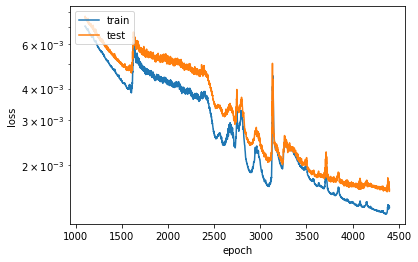

In [ ]:
agents_light[0].fit(epochs=4000)

 init residu:
Erreur G(u0):  2859.861994199179
Erreur G(0):  8176.906653133467
 last test : agent solution
>>>> nb iter to converge >> 60  final error >> 7.516716977525462e-07  message >> A solution was found at the specified tolerance.
>>>> Test final
Erreur F_theta(0)-U_ref:  0.018787890054173407
 init residu:
Erreur G(u0):  2859.861994199179
Erreur G(0):  8176.906653133467
 last test : basic solution
>>>> nb iter to converge >> 181  final error >> 6.943628536030299e-07  message >> A solution was found at the specified tolerance.
>>>> Test final


181

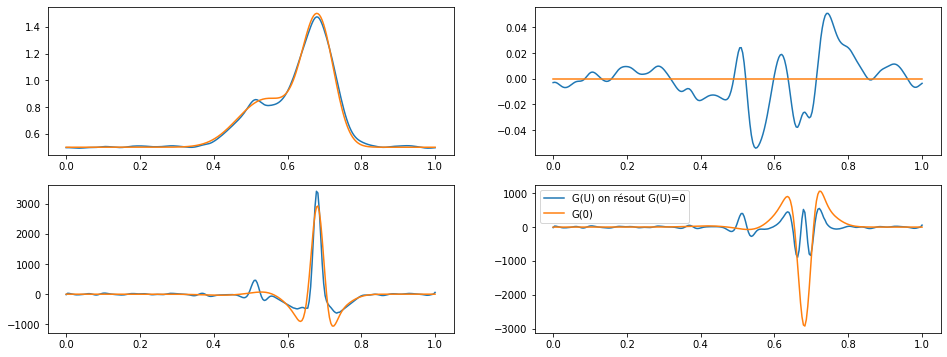

In [ ]:
i0=0
agents_light[0].test_inverse_train(i0,True)
agents_light[0].test_inverse_train(i0,False)

## code un truc qui renvoit le nombre d'iteration moyenne sur plusieurs simulation

Size of problem: (700, 1)  init residu:
Erreur G(u0):  3957.562462171522
Erreur G(0):  6538.008340471941
 last test : basic solution
 last test : agent solution
>>>> Basic: nb iter to converge >> 1242  final error >> 9.781862420953656e-07  message >> A solution was found at the specified tolerance.
>>>> Agent: nb iter to converge >> 580  final error >> 9.54025106282279e-07  message >> A solution was found at the specified tolerance.
>>>> Test final
Erreur F_theta(0)-U_ref:  0.012292719145709051


580

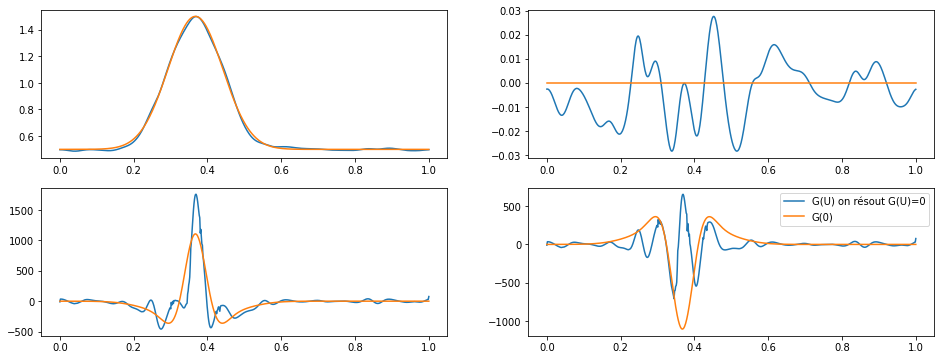

In [ ]:
agents_light[0].test_inverse_test(True,True)


In [ ]:
ratio_i,ratio_t,tmesh,r_mesh,nb_ratio_larger_un,mean_i,mean_t,mean_mesh_i,mean_mesh_t,nb_mesh=agents_light[0].output_stats(40,True)
print("moyenne global>>> ",mean_i," ",mean_t)
for i in range(0,len(nb_mesh)):
  print("moyenne global du mesh de talle >>>",agents_light[0].Newton_test.meshes[i],">>> ",mean_mesh_i[i]," ",mean_mesh_t[i])

>>> iter >>> 0
>>> iter >>> 10
>>> iter >>> 20
>>> iter >>> 30
moyenne global>>>  6.015315513615225   3.5916221494709526
moyenne global du mesh de talle >>> 80 >>>  3.6458371422516707   3.5144945335455957
moyenne global du mesh de talle >>> 100 >>>  1.1912231527599364   1.189710564602733
moyenne global du mesh de talle >>> 128 >>>  34.605299983079185   14.518346537321083
moyenne global du mesh de talle >>> 200 >>>  8.792307567497405   5.9637590255585
moyenne global du mesh de talle >>> 256 >>>  2.270671834625323   1.9441922790124504
moyenne global du mesh de talle >>> 400 >>>  3.3963498914597654   2.7343059490656327
moyenne global du mesh de talle >>> 512 >>>  1.476943177786958   1.4069941490511333
moyenne global du mesh de talle >>> 700 >>>  1.0776745682012847   1.0591803978403644


In [ ]:
print(ratio_i)

[1.07603687 1.54423592 0.25520263 1.16099071 1.25503356 2.408
 0.97159091 1.15879828 3.28407225 1.4973262 ]


In [ ]:
ratio_i,ratio_t,tmesh,r_mesh,nb_ratio_larger_un,mean_i,mean_t,mean_mesh_i,mean_mesh_t,nb_mesh=agents_light[0].output_stats(50,True)

In [ ]:
def plot_histo(agent,ratio,rmesh):
  block_ratio=np.array([0.0,0.5,0.8,1.0,1.25,1.5,2.0,3.0,6.0,11.0,16.0,31.0,51.0,100.0])
  percent=np.array(['-100%','-50%','-20%','0%','25%','50%','100%','200%','500%','1000%','1500%','3000%','5000%','10000%'])
  N=agent.Newton_train.N
  Nv=[80,100,128,200,256,400,512,700]
  ratio_mesh=np.array([ agent.Newton_test.meshes[i]/N for i in range(0,len(Nv))])

  z_histo=np.zeros(((len(block_ratio)-1),len(ratio_mesh)))

  for i in range(0,len(ratio)):
    for j in range(0,len(block_ratio)-1):
      if block_ratio[j] <= ratio[i] < block_ratio[j+1]:
        for v in range(0,len(ratio_mesh)):
          if abs(rmesh[i]- ratio_mesh[v])<0.0001:
            z_histo[j,v]+=1
  plt.imshow(z_histo)

  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(projection='3d')
  xedges=np.arange(len(block_ratio)-1)
  yedges=np.arange(len(ratio_mesh))
# Construct arrays for the anchor positions of the 16 bars.
  xpos, ypos = np.meshgrid(xedges + 0.25, yedges + 0.9, indexing="ij")
  xpos = xpos.ravel()
  ypos = ypos.ravel()
  zpos = 0
# Construct arrays with the dimensions for the 16 bars.
  dx = dy = 0.5 * np.ones_like(zpos)
  dz = z_histo.ravel()

  cmap = cm.get_cmap('Reds') # Get desired colormap - you can change this!
  max_height = np.max(dz) # get range of colorbars so we can normalize
  min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
  rgba = [cmap((k-min_height)/max_height) for k in dz]

  ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba ,zsort='average')
  ax.set_xticks(np.arange(len(block_ratio)))
  ax.set_yticks(1+yedges)
  ax.set_xticklabels(percent)
  ax.set_yticklabels(ratio_mesh,rotation=-15,
  verticalalignment='baseline',
  horizontalalignment='left')
  ax.view_init(45,120)
  plt.show()

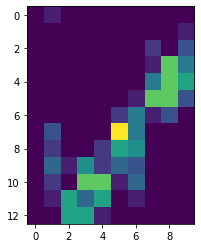

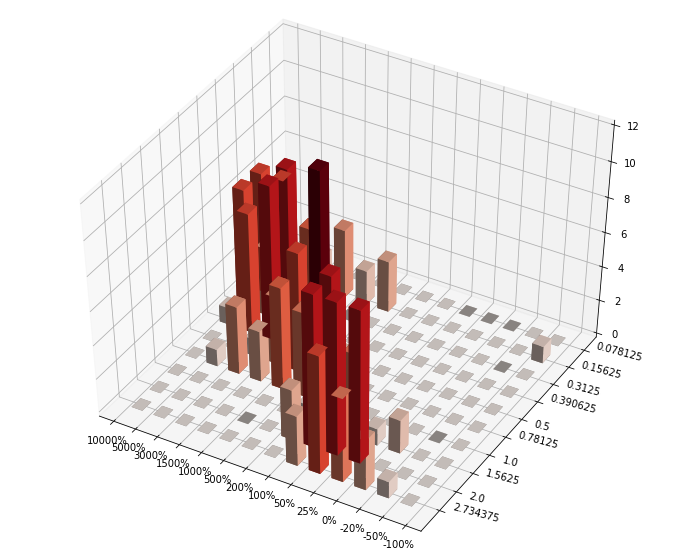

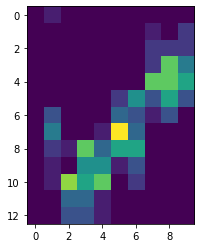

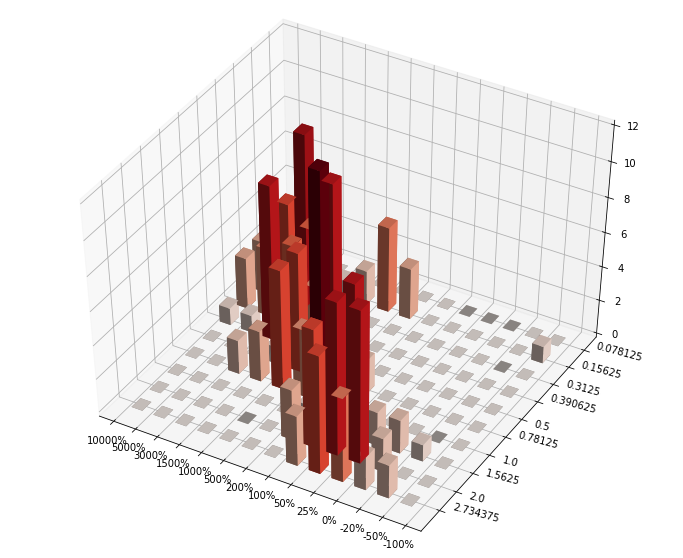

In [ ]:
plot_histo(ratio_i,rmesh)

plot_histo(ratio_t,rmesh)


## Entrainement avec algorithme génétique Score 1

In [ ]:
ku2     = lambda u : u**4 +1.0   
kpu2    = lambda u : 4.0*u*u*u 
#ku2     = lambda u : np.ones_like(u)
#kpu2    = lambda u : np.zeros_like(u)
Newton_train2=Newton(N=256,a=0.0,b=1.0,k=ku2,kp=kpu2,nb_eq=1200,nb_sol_by_eq=1)
Newton_test2=Newton(N=256,a=0.0,b=1.0,k=ku2,kp=kpu2)
Newton_train2.generate_data_train()

====== Init ======
mesh size:  1
mesh step:  0.00392156862745098
bc type  :  Neumann
====== Init ======
mesh size:  1
mesh step:  0.00392156862745098
bc type  :  Neumann
>>> end generate >>>


In [ ]:
popsize = 5
#Unet_struc=(5,6,7,2)
#NN_Unet=Unet(Unet_struc) 

NN_FNO2 = FNO1d_plus(modes=12, width=16,out_channels=1,first_channel_unchanged=True,pad_prop=0.05,freq_mix_size=5)

agents_light2=[Agent_Newton(
    Newton=Newton_train2,
    Newton_test=Newton_test2,
    model=NN_FNO2, #NN_Unet,
    lr0=0.0008,
    reg=0.0001,
    decay=0.988,
    batch_size=32,
    n_lissage=10,
    omega=0.2,
    nb_opti=1000,
    type_score=1
) for _ in range(popsize)]

if agents_light2[0].nn_name=='Unet':
  for _ in range(popsize):
      agents_light2[0].model.summary()


family_trainers2 = [
    pop.Family_trainer(agents_light2, period_duration="900 seconds",name="light",color="g"),
]

modèle FNO1d crée avec comme hyperparamètre: modes:12, width:16,level:4, pad_prop:0.05 
nb pixel lissage >>> 27
omega>> 0.2
nb pixel lissage >>> 27
omega>> 0.2
nb pixel lissage >>> 27
omega>> 0.2
nb pixel lissage >>> 27
omega>> 0.2
nb pixel lissage >>> 27
omega>> 0.2


In [ ]:
try:
    for _ in range(10):
        Newton_train2.generate_data_train()
        Newton_train2.shuffle()
        for fm in family_trainers2:
            fm.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers2:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()
    print("interuption manuelle")

>>> end generate >>>

light,échauffement a↗12.8224b↗11.1187c↗15.4983d↗11.4425e↗13.8201>>> end generate >>>

light,period:1 a↗15.9969b↗14.9562, mutations:d⇇a|>>> end generate >>>

light,period:2 c↗20.1262, mutations:b⇇c|>>> end generate >>>

light,period:3 -, mutations:d⇇a⇇c|>>> end generate >>>

light,period:4 -, mutations:e⇇c|>>> end generate >>>

light,period:5 a↗27.0637, mutations:c⇇a|>>> end generate >>>

light,period:6 -, mutations:b⇇c⇇a|>>> end generate >>>

light,period:7 -, mutations:a⇇a|>>> end generate >>>

light,period:8 d↗14.6238, mutations:d⇇a⇇c⇇a|>>> end generate >>>

light,period:9 e↗20.1522, mutations:e⇇c⇇a|

In [ ]:
best_agents=[fm.get_best_agent() for fm in family_trainers2]


In [ ]:
ratio_i,ratio_t,tmesh,r_mesh,nb_ratio_larger_un,mean_i,mean_t,mean_mesh_i,mean_mesh_t,nb_mesh=agents_light[0].output_stats(10,True)
print("moyenne global>>> ",mean_i," ",mean_t)
for i in range(0,len(nb_mesh)):
  print("moyenne global du mesh de talle >>>",agents_light[0].Newton_test.meshes[i],">>> ",mean_mesh_i[i]," ",mean_mesh_t[i])

>>>> Basic: nb iter to converge >> 475  final error >> 5.712337568150013e-07  message >> A solution was found at the specified tolerance.
>>>> Agent: nb iter to converge >> 16  final error >> 4.691531663677992e-08  message >> A solution was found at the specified tolerance.
>>>> ratio >>>> 29.6875 >>>> tratio >>>> 23.54064193568298  >>> ratio mesh >>>  0.5
>>>> Basic: nb iter to converge >> 323  final error >> 8.379108286339358e-07  message >> A solution was found at the specified tolerance.
>>>> Agent: nb iter to converge >> 181  final error >> 8.558015134573869e-07  message >> A solution was found at the specified tolerance.
>>>> ratio >>>> 1.7845303867403315 >>>> tratio >>>> 0.7607348186606627  >>> ratio mesh >>>  1.5625
>>>> Basic: nb iter to converge >> 532  final error >> 4.6802333924842155e-07  message >> A solution was found at the specified tolerance.
>>>> Agent: nb iter to converge >> 54  final error >> 7.639539113464743e-07  message >> A solution was found at the specified t

In [ ]:
print("lissage >>",best_agents[0].famparams["n_lissage"])
print("omega >>",best_agents[0].famparams["omega"])
print("lr0 >>",best_agents[0].famparams["lr0"])

lissage >> 8
omega >> 1.0
lr0 >> 0.0009486175489069093


In [ ]:
ratio_i,ratio_t,tmesh,r_mesh,nb_ratio_larger_un,mean_i,mean_t,mean_mesh_i,mean_mesh_t,nb_mesh=agents_light[0].output_stats(200,False)
print("moyenne global>>> ",mean_i," ",mean_t)
for i in range(0,len(nb_mesh)):
  print("moyenne global du mesh de talle >>>",agents_light[0].Newton_test.meshes[i],">>> ",mean_mesh_i[i]," ",mean_mesh_t[i])

>>> iter >>> 0
>>> iter >>> 10
>>> iter >>> 20
>>> iter >>> 30
>>> iter >>> 40
>>> iter >>> 50
>>> iter >>> 60
>>> iter >>> 70
>>> iter >>> 80
>>> iter >>> 90
>>> iter >>> 100
>>> iter >>> 110
>>> iter >>> 120
>>> iter >>> 130
>>> iter >>> 140
>>> iter >>> 150
>>> iter >>> 160
>>> iter >>> 170
>>> iter >>> 180
>>> iter >>> 190


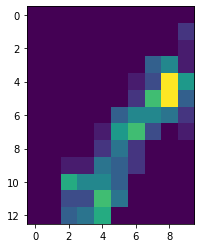

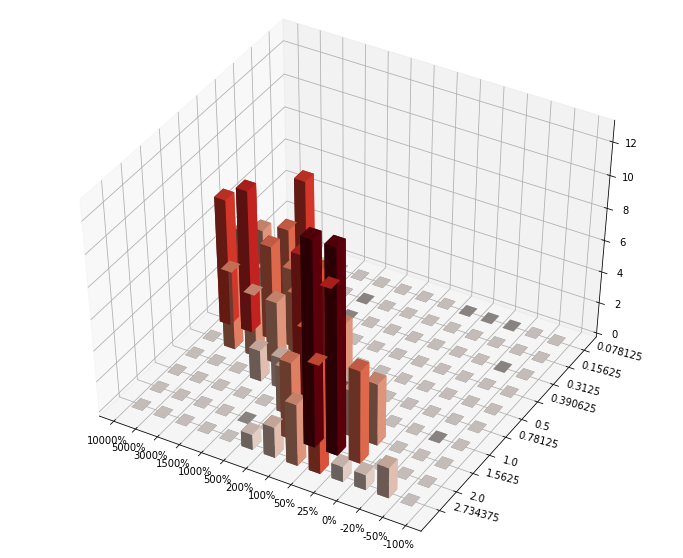

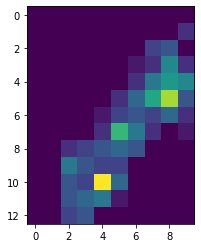

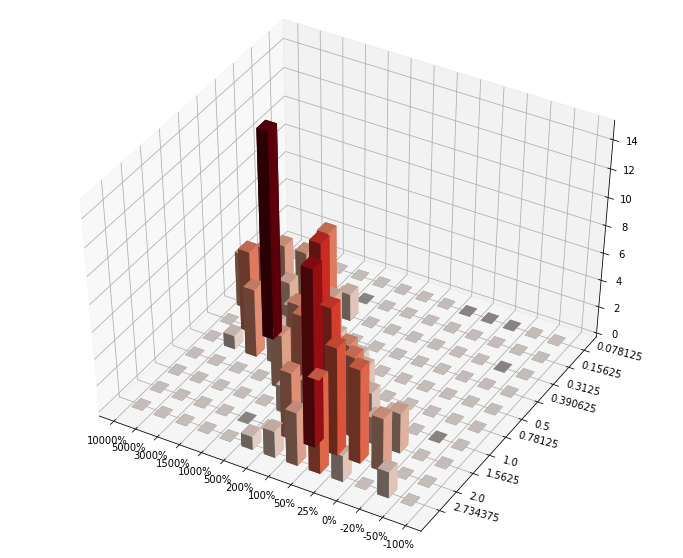

In [ ]:
plot_histo(tratio_i2,rmesh2)

plot_histo(tratio_t2,rmesh2)